In [1]:
!wget https://www.dropbox.com/s/2zqk3l0wmhkn7bb/train.zip
!wget https://www.dropbox.com/s/18excx86hgyfssk/test1.zip
!wget https://www.dropbox.com/s/7sfkltyrrmfzahq/sampleSubmission.csv

--2021-01-24 14:20:58--  https://www.dropbox.com/s/2zqk3l0wmhkn7bb/train.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/2zqk3l0wmhkn7bb/train.zip [following]
--2021-01-24 14:20:59--  https://www.dropbox.com/s/raw/2zqk3l0wmhkn7bb/train.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6c89f61a29055fdbf95a0a2f3f.dl.dropboxusercontent.com/cd/0/inline/BHkonFCxenIB7xT0GXYzc5rKb1thTyz65nKFClk-5wSjyFeWw8nIHA5hpLl4cGZRsmRgTVHd_6t6ZigGsnQIkr1oZAbk4-rHDu592ZMyBR6IUUmeXteLCEElj_DrHzbJETI/file# [following]
--2021-01-24 14:20:59--  https://uc6c89f61a29055fdbf95a0a2f3f.dl.dropboxusercontent.com/cd/0/inline/BHkonFCxenIB7xT0GXYzc5rKb1thTyz65nKFClk-5wSjyFeWw8nIHA5hpLl4cGZRsmRgTVHd_6t6ZigGsnQIkr1oZAbk4-rHDu592ZMyBR6IUUmeXteLCEEl

In [2]:
!unzip -q train.zip
!unzip -q test1.zip

!rm train.zip
!rm test1.zip

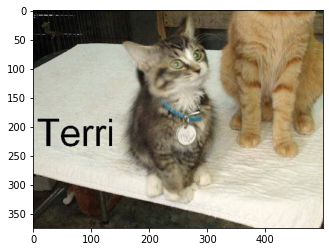

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd

img = mpimg.imread('train/cat.555.jpg')
plt.imshow(img)

In [4]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os


filenames = os.listdir("train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append("dog")
    else:
        categories.append("cat")

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

,filename,category
0,dog.8774.jpg,dog
1,cat.1146.jpg,cat
2,dog.9164.jpg,dog
3,cat.11968.jpg,cat
4,dog.10287.jpg,dog


In [39]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

model = Sequential()

model.add(Conv2D(512, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_197 (Conv2D)          (None, 126, 126, 512)     14336     
_________________________________________________________________
batch_normalization_200 (Bat (None, 126, 126, 512)     2048      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 63, 63, 512)       0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 63, 63, 512)       0         
_________________________________________________________________
conv2d_198 (Conv2D)          (None, 61, 61, 128)       589952    
_________________________________________________________________
batch_normalization_201 (Bat (None, 61, 61, 128)       512       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 30, 30, 128)      

In [11]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [12]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15


train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [40]:
epochs=20
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/20
1333/1333 [==============================] - 147s 109ms/step - loss: 0.9637 - acc: 0.5617 - val_loss: 0.6121 - val_acc: 0.6557
Epoch 2/20
1333/1333 [==============================] - 145s 109ms/step - loss: 0.5625 - acc: 0.7141 - val_loss: 0.4555 - val_acc: 0.7900
Epoch 3/20
1333/1333 [==============================] - 145s 109ms/step - loss: 0.4914 - acc: 0.7646 - val_loss: 0.7024 - val_acc: 0.7137
Epoch 4/20
1333/1333 [==============================] - 145s 108ms/step - loss: 0.4434 - acc: 0.7972 - val_loss: 0.3893 - val_acc: 0.8234
Epoch 5/20
1333/1333 [==============================] - 144s 108ms/step - loss: 0.4115 - acc: 0.8186 - val_loss: 0.4340 - val_acc: 0.8006
Epoch 6/20
1333/1333 [==============================] - 145s 108ms/step - loss: 0.3984 - acc: 0.8234 - val_loss: 0.7699 - val_acc: 0.7401

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/20
1333/1333 [==============================] - 144s 108ms/step - loss: 0.3678 - ac

In [41]:
model.save("scratch_model.h5")

In [43]:
# aa = pd.DataFrame.from_dict(history_model_1.history).to_csv('history.csv',index=False)
aa = pd.DataFrame.from_dict(history.history)
a

,loss,acc,val_loss,val_acc,lr
0,0.760033,0.614761,0.612098,0.655656,0.001000
1,0.536884,0.731248,0.455464,0.789990,0.001000
2,0.474359,0.776582,0.702360,0.713714,0.001000
3,0.434216,0.804653,0.389257,0.823423,0.001000
4,0.408887,0.817913,0.434019,0.800601,0.001000
5,0.393414,0.825619,0.769869,0.740140,0.001000
6,0.357183,0.848837,0.348520,0.855656,0.000500
7,0.343699,0.852890,0.302971,0.875275,0.000500
8,0.335194,0.858744,0.281794,0.882282,0.000500
9,0.323003,0.863848,0.306860,0.875475,0.000500


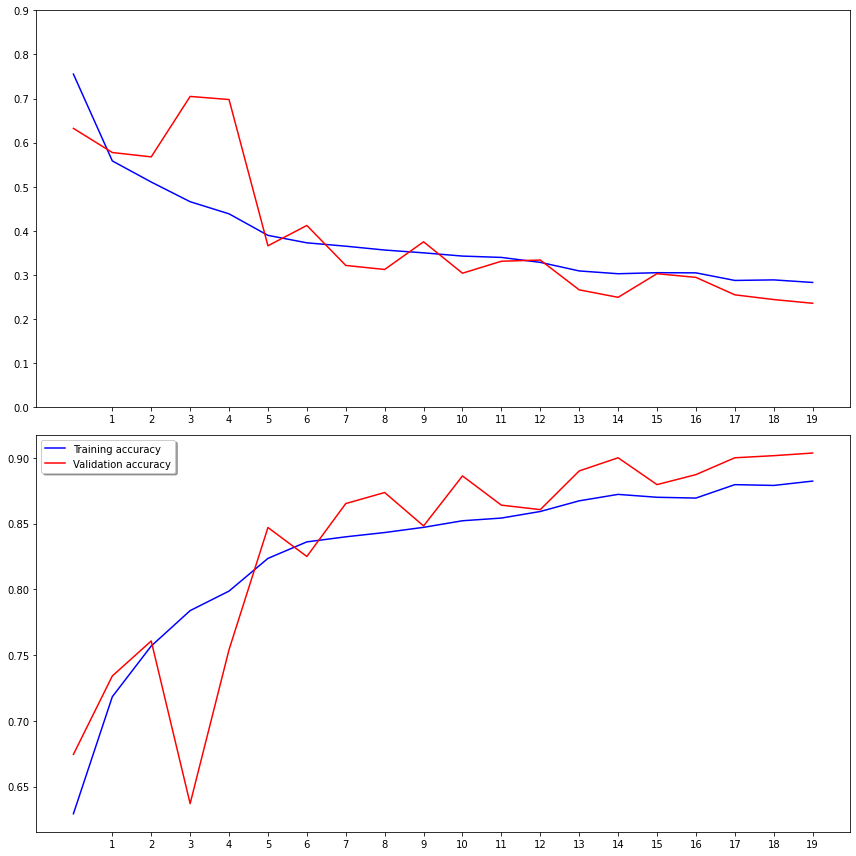

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
test_filenames = os.listdir("test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
total_test = test_df.shape[0]

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)


print("Evaluate on test data")
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

Found 12500 validated image filenames.
Evaluate on test data


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


#VGG-19

In [18]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop

vgg_base_model = VGG19(input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

for layer in vgg_base_model.layers:
    layer.trainable = False


# Flatten the output layer to 1 dimension
x = Flatten()(vgg_base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = Dropout(0.5)(x)

# Add a final softmax layer for classification
x = Dense(2, activation='softmax')(x)

vgg_model = Model(vgg_base_model.input, x)

vgg_model.compile(optimizer = RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

80142336/80134624 [==============================] - 1s 0us/step


In [19]:
vgghist = vgg_model.fit(
    train_generator, 
    epochs=20,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/20
1333/1333 [==============================] - 140s 104ms/step - loss: 0.5030 - acc: 0.7565 - val_loss: 0.3036 - val_acc: 0.8645
Epoch 2/20
1333/1333 [==============================] - 140s 105ms/step - loss: 0.3794 - acc: 0.8330 - val_loss: 0.3159 - val_acc: 0.8667
Epoch 3/20
1333/1333 [==============================] - 139s 104ms/step - loss: 0.3605 - acc: 0.8448 - val_loss: 0.2906 - val_acc: 0.8759
Epoch 4/20
1333/1333 [==============================] - 139s 105ms/step - loss: 0.3557 - acc: 0.8491 - val_loss: 0.3179 - val_acc: 0.8709
Epoch 5/20
1333/1333 [==============================] - 140s 105ms/step - loss: 0.3565 - acc: 0.8537 - val_loss: 0.2981 - val_acc: 0.8715

Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 6/20
1333/1333 [==============================] - 141s 105ms/step - loss: 0.3407 - acc: 0.8554 - val_loss: 0.3108 - val_acc: 0.8753
Epoch 7/20
1333/1333 [==============================] - 141s 106ms/step - loss: 0.3325 - ac

In [28]:
vgg_model.save("vgg_model.h5")

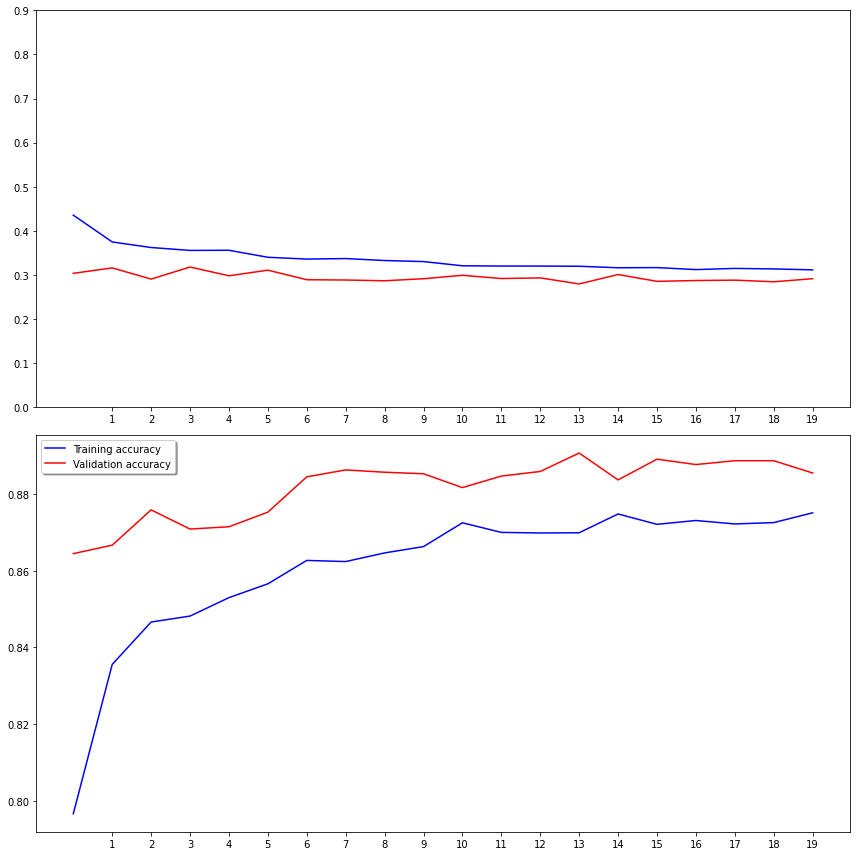

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(vgghist.history['loss'], color='b', label="Training loss")
ax1.plot(vgghist.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(vgghist.history['acc'], color='b', label="Training accuracy")
ax2.plot(vgghist.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

#INCEPTION V3

In [29]:
from tensorflow.keras.applications.inception_v3 import InceptionV3


inc_base_model = InceptionV3(input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3), include_top = False, weights = 'imagenet')

for layer in inc_base_model.layers:
    layer.trainable = False


x = Flatten()(inc_base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(2, activation='softmax')(x)

inc_model = Model(inc_base_model.input, x)

inc_model.compile(optimizer = RMSprop(lr=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [30]:
epochs=20
inc_history = inc_model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/20
1333/1333 [==============================] - 149s 109ms/step - loss: 0.4854 - acc: 0.8846 - val_loss: 0.1845 - val_acc: 0.9337
Epoch 2/20
1333/1333 [==============================] - 142s 106ms/step - loss: 0.2364 - acc: 0.9198 - val_loss: 0.1712 - val_acc: 0.9399
Epoch 3/20
1333/1333 [==============================] - 142s 106ms/step - loss: 0.2312 - acc: 0.9223 - val_loss: 0.1522 - val_acc: 0.9435
Epoch 4/20
1333/1333 [==============================] - 141s 106ms/step - loss: 0.2204 - acc: 0.9260 - val_loss: 0.1703 - val_acc: 0.9435
Epoch 5/20
1333/1333 [==============================] - 140s 105ms/step - loss: 0.2055 - acc: 0.9289 - val_loss: 0.1609 - val_acc: 0.9493
Epoch 6/20
1333/1333 [==============================] - 141s 106ms/step - loss: 0.2024 - acc: 0.9323 - val_loss: 0.1469 - val_acc: 0.9465
Epoch 7/20
1333/1333 [==============================] - 141s 105ms/step - loss: 0.2012 - acc: 0.9366 - val_loss: 0.1795 - val_acc: 0.9399

Epoch 00007: ReduceLROnPlateau re

In [31]:
inc_model.save("inc_model.h5")

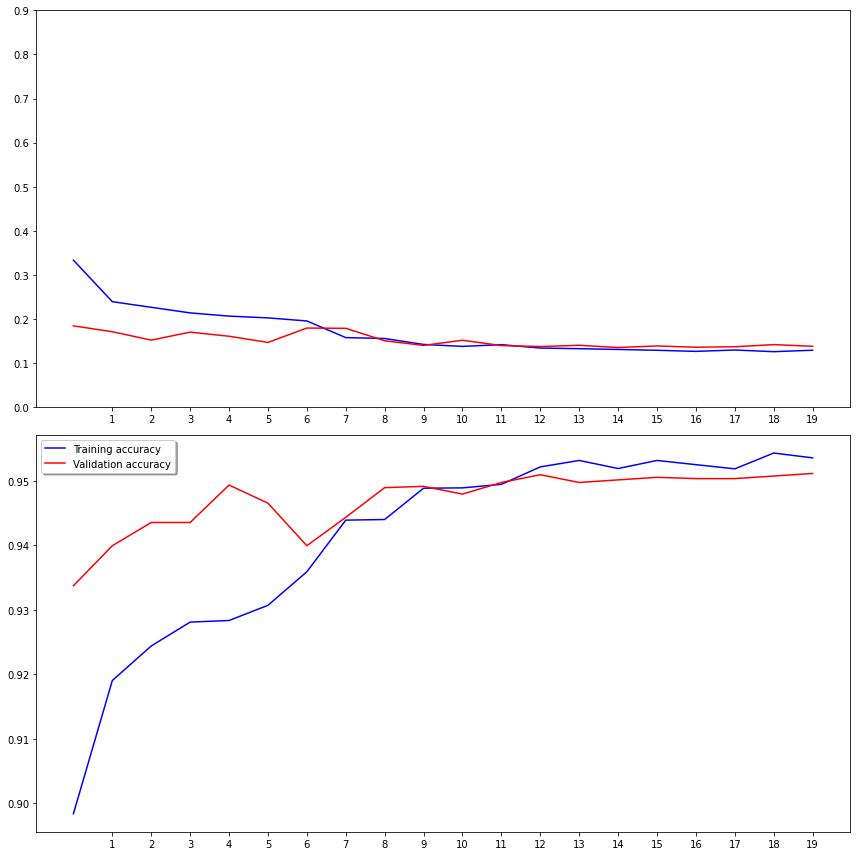

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(inc_history.history['loss'], color='b', label="Training loss")
ax1.plot(inc_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(inc_history.history['acc'], color='b', label="Training accuracy")
ax2.plot(inc_history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

#RESNET50

In [33]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import SGD

rn_base_model = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")

for layer in rn_base_model.layers:
    layer.trainable = False


rn_base_model = Sequential()
rn_base_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
rn_base_model.add(Dense(2, activation='softmax'))
rn_base_model.compile(optimizer = SGD(lr=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

94773248/94765736 [==============================] - 1s 0us/step


In [34]:
resnet_history = rn_base_model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/20
1333/1333 [==============================] - 153s 111ms/step - loss: 1.0855 - acc: 0.7335 - val_loss: 0.4050 - val_acc: 0.8999
Epoch 2/20
1333/1333 [==============================] - 148s 111ms/step - loss: 0.4717 - acc: 0.8759 - val_loss: 0.3056 - val_acc: 0.9265
Epoch 3/20
1333/1333 [==============================] - 146s 109ms/step - loss: 0.4049 - acc: 0.8920 - val_loss: 0.2635 - val_acc: 0.9333
Epoch 4/20
1333/1333 [==============================] - 148s 111ms/step - loss: 0.3497 - acc: 0.9013 - val_loss: 0.2650 - val_acc: 0.9299
Epoch 5/20
1333/1333 [==============================] - 147s 110ms/step - loss: 0.3169 - acc: 0.9123 - val_loss: 0.2302 - val_acc: 0.9389
Epoch 6/20
1333/1333 [==============================] - 147s 110ms/step - loss: 0.2855 - acc: 0.9210 - val_loss: 0.2042 - val_acc: 0.9443
Epoch 7/20
1333/1333 [==============================] - 146s 110ms/step - loss: 0.2741 - acc: 0.9224 - val_loss: 0.2028 - val_acc: 0.9453
Epoch 8/20
1333/1333 [============

In [35]:
rn_base_model.save("resnet_model.h5")

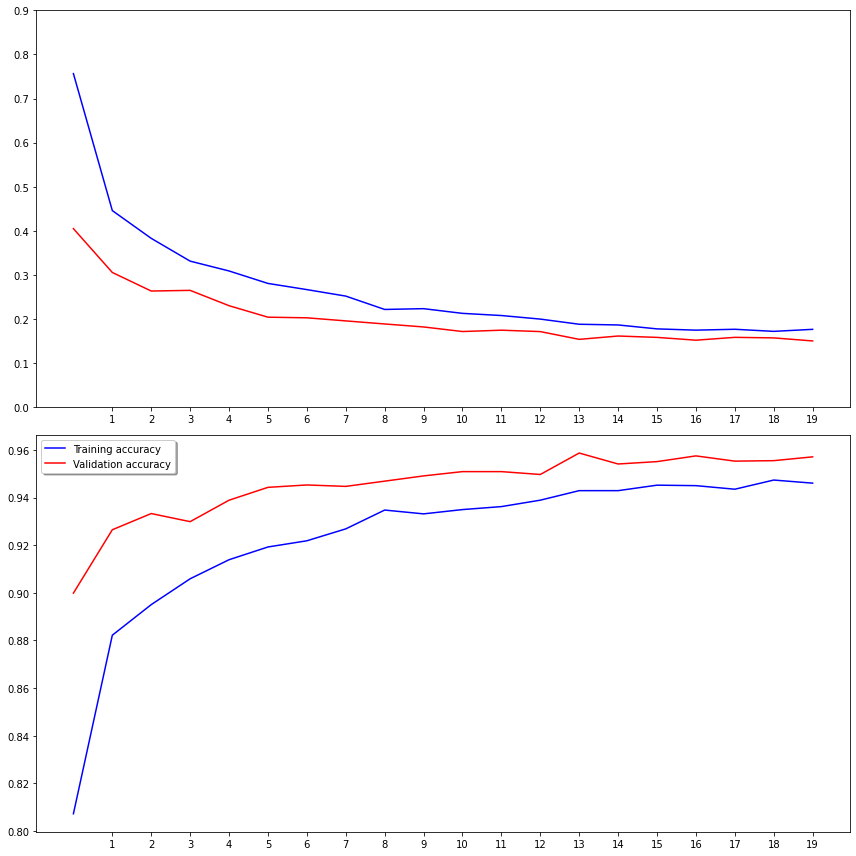

In [36]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(resnet_history.history['loss'], color='b', label="Training loss")
ax1.plot(resnet_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(resnet_history.history['acc'], color='b', label="Training accuracy")
ax2.plot(resnet_history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

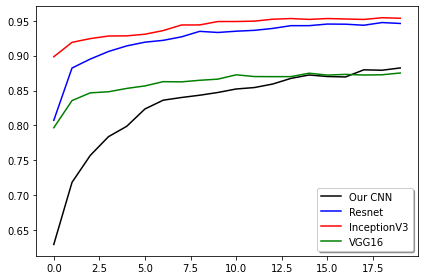

In [38]:
plt.plot(history.history['acc'], color='black', label="Our CNN")
plt.plot(resnet_history.history['acc'], color='b', label="Resnet")
plt.plot(inc_history.history['acc'], color='r', label="InceptionV3")
plt.plot(vgghist.history['acc'], color='g', label="VGG16")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [44]:
cnn_hist = pd.DataFrame.from_dict(history.history).to_csv('cnn_history.csv', index=False)
vgg_hist = pd.DataFrame.from_dict(vgghist.history).to_csv('vgg_history.csv', index=False)
inc_hist = pd.DataFrame.from_dict(inc_history.history).to_csv('inc__history.csv', index=False)
rn_hist = pd.DataFrame.from_dict(resnet_history.history).to_csv('resnet_history.csv', index=False)

In [ ]:
from tensorflow.keras.applications import EfficientNetB7

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

eff_base_model = EfficientNetB7(input_shape=(224, 224,3), include_top=False, weights="imagenet")

for layer in eff_base_model.layers:
    layer.trainable = False


eff_base_model = Sequential()
eff_base_model.add(EfficientNetB7(include_top=False, weights='imagenet', pooling='max'))
eff_base_model.add(Dense(2, activation='softmax'))
eff_base_model.compile(optimizer = SGD(lr=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

258080768/258076736 [==============================] - 2s 0us/step


In [ ]:
eff_history = eff_base_model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/20
1333/1333 [==============================] - 352s 248ms/step - loss: 0.9129 - acc: 0.5151 - val_loss: 0.7774 - val_acc: 0.6074
Epoch 2/20
1333/1333 [==============================] - 326s 245ms/step - loss: 0.7497 - acc: 0.6296 - val_loss: 0.6976 - val_acc: 0.6727
Epoch 3/20
  57/1333 [>.............................] - ETA: 4:53 - loss: 0.7248 - acc: 0.6309

KeyboardInterrupt: ignored